# **Classification des email spam/non spam**

**ce TP est réalisé par le quadrinome :**

*   Manel Rahiche
*   Khadidja Hammouda
*   Raissa Mezine

**Importation des librairies nécessaires**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import email
import string
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed(49)

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Lecture du dataset

In [ ]:
easy_ham_path = '/content/drive/MyDrive/dataset/easy_ham/easy_ham/'
hard_ham_path = '/content/drive/MyDrive/dataset/hard_ham/hard_ham/'
spam_path = '/content/drive/MyDrive/dataset/spam_2/spam_2/'

In [ ]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

In [ ]:
easy_ham = get_data(easy_ham_path)
hard_ham = get_data(hard_ham_path)
ham = easy_ham + hard_ham
spam = get_data(spam_path)

In [ ]:
len(spam)

1397

In [ ]:
np.random.shuffle(ham)
np.random.shuffle(spam)

# Afficher un exemple du dataset

In [ ]:
print(spam[0])

From fork-admin@xent.com  Thu Aug  8 14:37:07 2002
Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id C8B9944203
	for <jm@localhost>; Thu,  8 Aug 2002 08:40:29 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Thu, 08 Aug 2002 13:40:29 +0100 (IST)
Received: from webnote.net (mail.webnote.net [193.120.211.219]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g78CIL202281 for
    <jm@JMASON.ORG>; Thu, 8 Aug 2002 13:18:21 +0100
Received: from xent.com ([64.161.22.236]) by webnote.net (8.9.3/8.9.3)
    with ESMTP id KAA29221 for <jm@jmason.org>; Thu, 8 Aug 2002 10:58:18 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id 4DF4F29409D; Thu,  8 Aug 2002 02:43:08 -0700 (PDT)
Delivered-To: fork@spamassassin.taint.org
Received: from hotmail.

# Partie 1: Nettoyage du dataset

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
class clean_dataset(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail)
            body = ""

            if b.is_multipart():
                for part in b.walk():
                    ctype = part.get_content_type()
                    cdispo = str(part.get('Content-Disposition'))
                    if ctype == 'text/plain' and 'attachment' not in cdispo:
                        body = part.get_payload(decode=True)  
                        break
            else:
                body = b.get_payload(decode=True) # récupérer le corp de l'email
            soup = BeautifulSoup(body, "html.parser") 
            text = soup.get_text().lower()
            text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'httpaddr', text, flags=re.MULTILINE) #remove links
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', text, flags=re.MULTILINE) #remove email addresses
            text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
            text = re.sub(r'\d+', 'nombre', text, flags=re.MULTILINE)
            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words] # remove stop words
            words_list = [lemmatizer.lemmatize(w) for w in words_list] 
            words_list = [stemmer.stem(w) for w in words_list] 
            text_list.append(' '.join(words_list))
        return text_list

In [ ]:
email_to_text = clean_dataset()
text_ham = email_to_text.transform(ham)
text_spam = email_to_text.transform(spam)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


# Affichage d'un exemple du dataset aprés nettoyage

In [ ]:
text_ham[1]

'origin messag gari lawrenc murphi one thing think weve learn time helpdesk doesnt work im sure strictli helpdesk stuff whole right mind would use doesnt cool featur isnt alway guarante failur mayb strength approach agent andor im ui find nich applic space prologbas nl databas queri system nombr later chatterbot helpdesk project like shallow red even simpler tri like ask jeev peopl quickli know theyr talk robot queri anneal short truncat ters databaselik verbnoun nounkeyword request kind like web queri googl someon els turn link dont even type anyth peopl quick adapt impati forgiv clunki interfac especi averag comput user still cant type mayb nombrewpm nl pain slow clunki interfac ye true true put way would login wake bot ask seattl weather would click weather icon sit desktop situat dont directli asktalk bot listen advisecorrectinterjectetc exampl two peopl discuss trip etc may trigger weather bot mention forecast say without directli ask'

# Statiqtique sur le dataset

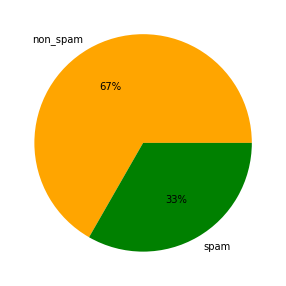

In [ ]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['non_spam', 'spam']
colors = ['orange', 'green']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

# PARTIE 2: Création du dictionnaire

In [ ]:
y = len(text_ham)*[0] + len(text_spam)*[1]
print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_ham+text_spam, y,stratify=y, test_size=0.2)

In [ ]:
import json
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
vocabulaire=vectorizer.vocabulary_
print(len(vocabulaire))
with open("vocabulaire.json", "w") as outfile:
    json.dump(vocabulaire, outfile)
X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

35779


In [ ]:
from google.colab import files
files.download('vocabulaire.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print('size of trainning data',X_train.shape)
print('size of testing data',X_test.shape)

size of trainning data (3358, 35779)
size of testing data (840, 35779)


# Partie 3: Classifier les email en utilisant les algorithme suivants:


*   Machine de vécteurs de support (SVM)
*   Le plus proche voisins (KNN)
*   Les arbres de décision




# SVM

In [ ]:
from sklearn import svm
model = svm.SVC(kernel='linear',C=0.1)
#model = svm.SVC(kernel='rbf', gamma=0.1)
model.fit(X_train,y_train)

SVC(C=0.1, kernel='linear')

In [ ]:
predictions=model.predict(X_test)

# Evaluer le classifieur SVM

In [ ]:
#print('Training Accuracy: {0:.2f}%'.format(np.mean((predictions == y_test).astype(int)) * 100))
print("accuracy score = {}%".format(round(accuracy_score(y_test, predictions)*100, 2)))

accuracy score = 97.14%


In [ ]:
from sklearn import metrics
#preds = model.predict(train_data)
targs = y_test 
print("accuracy: ", metrics.accuracy_score(targs, predictions))
print("precision: ", metrics.precision_score(targs, predictions)) 
print("recall: ", metrics.recall_score(targs, predictions))
print("f1: ", metrics.f1_score(targs, predictions))
print("area under curve (auc): ", metrics.roc_auc_score(targs, predictions))

accuracy:  0.9714285714285714
precision:  0.9571428571428572
recall:  0.9571428571428572
f1:  0.9571428571428572
area under curve (auc):  0.967857142857143


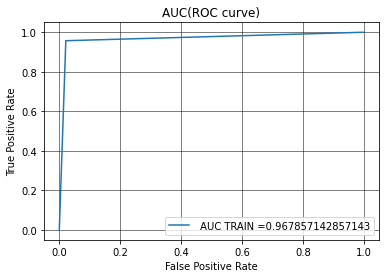

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_test , predictions)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
#plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
#plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(metric='euclidean')

In [ ]:
prediction_knn=knn_clf.predict(X_test)

# Evaluer le classifieur KNN

In [ ]:
print("accuracy score = {}%".format(round(accuracy_score(y_test, prediction_knn)*100, 2)))

accuracy score = 82.02%


In [ ]:
from sklearn import metrics
#preds = model.predict(train_data)
targs = y_test 
print("accuracy: ", metrics.accuracy_score(targs, prediction_knn))
print("precision: ", metrics.precision_score(targs, prediction_knn)) 
print("recall: ", metrics.recall_score(targs, prediction_knn))
print("f1: ", metrics.f1_score(targs, prediction_knn))
print("area under curve (auc): ", metrics.roc_auc_score(targs, prediction_knn))

accuracy:  0.8202380952380952
precision:  0.680672268907563
recall:  0.8678571428571429
f1:  0.7629513343799058
area under curve (auc):  0.8321428571428572


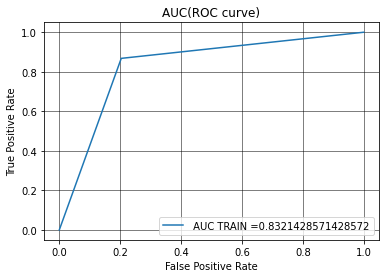

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_test , prediction_knn)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
#plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
#plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

# Arbres de décisions

In [ ]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
prediction_tree = tree_model.predict(X_test)

# Evaluer le classifieur Decisons Tree

In [ ]:
print("accuracy score = {}%".format(round(accuracy_score(y_test, prediction_tree)*100, 2)))

accuracy score = 92.62%


In [ ]:
from sklearn import metrics
targs = y_test 
print("accuracy: ", metrics.accuracy_score(targs, prediction_tree))
print("precision: ", metrics.precision_score(targs, prediction_tree)) 
print("recall: ", metrics.recall_score(targs, prediction_tree))
print("f1: ", metrics.f1_score(targs, prediction_tree))
print("area under curve (auc): ", metrics.roc_auc_score(targs, prediction_tree))

accuracy:  0.9261904761904762
precision:  0.8811188811188811
recall:  0.9
f1:  0.8904593639575972
area under curve (auc):  0.9196428571428571


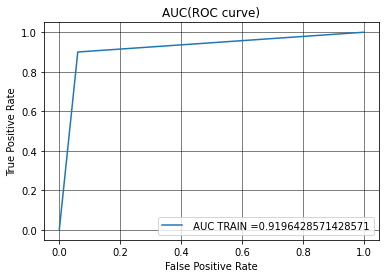

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_test , prediction_tree)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
#plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
#plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

# End